In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
#!pip install rich

In [ ]:
import re
import warnings
import string
import numpy as np 
import random
import pandas as pd 
from scipy import stats
import missingno as msno
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

#from rich.console import Console
#from rich.theme import Theme
#from rich import pretty

from PIL import Image

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression


from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

from collections import defaultdict
from collections import Counter

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import (
    mean_squared_error as mse, 
    make_scorer, 
    accuracy_score, 
    confusion_matrix
)

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend
from tensorflow.keras import optimizers, losses, metrics, Model
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)

from transformers import TFAutoModelForSequenceClassification, TFAutoModel, AutoTokenizer

In [ ]:
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 2021
seed_everything(seed)

In [ ]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 150)

In [ ]:
# Defining all our palette colours.
primary_blue = "#496595"
primary_blue2 = "#85a1c1"
primary_blue3 = "#3f4d63"
primary_grey = "#c6ccd8"
primary_black = "#202022"
primary_bgcolor = "#f4f0ea"

primary_green = px.colors.qualitative.Plotly[2]

plotly_discrete_sequence = px.colors.qualitative.G10

In [ ]:
colors = [primary_blue, primary_blue2, primary_blue3, primary_grey, primary_black, primary_bgcolor, primary_green]
sns.palplot(sns.color_palette(colors))

In [ ]:
sns.palplot(sns.color_palette(plotly_discrete_sequence))

In [ ]:
plt.rcParams['figure.dpi'] = 120
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.facecolor'] = primary_bgcolor

In [ ]:
custom_theme = Theme({
    "info" : "italic bold blue",
    "succeed": "italic bold green",
    "danger": "bold red"
})

console = Console(theme=custom_theme)

pretty.install()

<a id='1'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">1. Loading Data 💎</p>

Just load the dataset and global variables for colors and so on.

In [ ]:
train_df = pd.read_csv('/kaggle/input/commonlitreadabilityprize/train.csv')
test_df = pd.read_csv('/kaggle/input/commonlitreadabilityprize/test.csv')
sub_df = pd.read_csv('/kaggle/input/commonlitreadabilityprize/sample_submission.csv')

train_df.shape

In [ ]:
train_df.head()

In [ ]:
target_column = 'target'

train_df.head()

<a href="#table-of-content">back to table of content</a>
<a id='2'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">2. EDA 📊</p>

Now we are going to take a look about the target distribution, missings, messages length and so on.

<a id='2.1'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">2.1 Missing values</p>

As we can see, the only missing values are in: `url_legal` and `license`. For now, we are going to do an analysis based on the `excerpt` text so we can go ahead.

In [ ]:
msno.bar(train_df, color=primary_blue, sort="ascending", figsize=(10,5), fontsize=12)
plt.show()

<a id='2.2'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">2.2 Target and Std_err Distributions 📸</p>


In [ ]:
fig2 = ff.create_distplot([train_df[target_column]], [target_column], colors=[primary_blue],
                             bin_size=.05, show_rug=False)
plot_title = f"<span style='font-size:30px; font-family:Serif'><b>{target_column.capitalize()}</b> resume</span>"

fig = go.Figure()

mean_value = train_df[target_column].mean()

fig.add_vrect(
    x0=train_df[target_column].quantile(0.25), 
    x1=train_df[target_column].quantile(0.75), 
    annotation_text="IQR", 
    annotation_position="top left",
    fillcolor=primary_grey, 
    opacity=0.25, 
    line_width=2,
)

fig.add_trace(go.Scatter(
    fig2['data'][1],
    line=dict(
        color=primary_blue, 
        width=1.5,
    ),
    fill='tozeroy'
))

fig.add_vline(
    x=mean_value, 
    line_width=2, 
    line_dash="dash", 
    line_color=primary_black
)
fig.add_annotation(
    yref="y domain",
    x=mean_value,
    # The arrow head will be 40% along the y axis, starting from the bottom
    y=0.5,
    axref="x",
    ayref="y domain",
    ax=mean_value + 0.2*mean_value,
    ay=0.6,
    text=f"<span>{target_column.capitalize()} mean</span>",
    arrowhead=2,
)
fig.add_annotation(
    xref="x domain", yref="y domain",
    x=0.98, y=0.98,
    text=f"<span><b>Skew: %.2f</b></span>"%(train_df[target_column].skew()),
    bordercolor=primary_black,
    borderwidth=1.5, borderpad=2.5,
    showarrow=False,
)

fig.update_layout(
    showlegend=True,
    title_text=plot_title
)

fig.show()

In [ ]:
###### Helpers not used:

#fig.add_annotation(
#    yref="y3 domain",
#    xref="x3",
#    x=q1_value,
#    # The arrow head will be 40% along the y axis, starting from the bottom
#    y=0.95,
#    axref="x3",
#    ayref="y3 domain",
#    ay=0.95,
#    ax=q1_value + abs(0.2*q1_value),
#    text="Interquartile range (IQR)",
#    arrowhead=3,
#)


#fig.add_annotation(
#    yref="y3 domain",
#    xref="x3",
#    x=mean_value,
#    y=0.5,
#    axref="x3",
#    ayref="y3 domain",
#    ax=mean_value + 0.2*mean_value,
#    ay=0.6,
#    text=f"<span>{feature.capitalize()} mean</span>",
#    arrowhead=3,
#)


#fig.add_shape(go.layout.Shape(
#    type="line",
#    yref="y3 domain",
#    xref="x",
#    x0=mean_value,
#    y0=0,
#    x1=mean_value,
#    y1=1,
#    line=dict(
#        color=primary_black, 
#        width=2, 
#        dash="dash"
#    ),
#), row=3, col=1)

In [ ]:
def generate_feature_resume(df, feature):
    
    plot_title = f"<span style='font-size:30px; font-family:Serif'><b>{feature.capitalize()}</b> resume</span>"
    (osm, osr), (slope, intercept, r) = stats.probplot(df[feature], plot=None)
    
    q1_value = train_df[feature].quantile(0.25)
    mean_value = train_df[feature].mean()
    fig2 = ff.create_distplot([df[feature]], [feature], colors=[primary_blue],
                             bin_size=.05, show_rug=False)

    fig = make_subplots(
        rows=3, cols=2,
        specs=[
            [{"rowspan": 2}, {"rowspan": 2}],
            [None, None],
            [{"colspan": 2}, None]
        ],
        subplot_titles=(
            "Quantile-Quantile Plot",
            "Box Plot",
            "Distribution Plot"
        )
    )

    fig.add_trace(go.Scatter(
        x=osm,
        y=slope*osm + intercept,
        mode='lines',
        line={
            'color': '#c81515',
            'width': 2.5
        }

    ), row=1, col=1)
    
    ## QQ-Plot
    fig.add_trace(go.Scatter(
        x=osm,
        y=osr,
        mode='markers',
        marker={
            'color': primary_blue
        }
    ), row=1, col=1)

    ## Box Plot
    fig.add_trace(go.Box(
        y=df[feature], 
        name='',
        marker_color = primary_blue
    ), row=1, col=2)

    ## Distribution plot
    fig.add_trace(go.Scatter(
        fig2['data'][1],
        line=dict(
            color=primary_blue, 
            width=1.5,
        ),
        fill='tozeroy'
    ), row=3, col=1)
    
    ## InterQuartile Range (IQR)
    fig.add_vrect(
        x0=df[feature].quantile(0.25), 
        x1=df[feature].quantile(0.75), 
        annotation_text="IQR", 
        annotation_position="top left",
        fillcolor=primary_grey, 
        opacity=0.25, 
        line_width=2,
        row=3, col=1,
    )
    
    ## Mean line
    fig.add_vline(
        x=mean_value,
        line_width=2, 
        line_dash="dash", 
        line_color=primary_black,
        annotation_text="Mean", 
        annotation_position="bottom right",
        row=3, col=1,
    )
    
    fig.add_annotation(
        xref="x domain", yref="y domain",
        x=0.98, y=0.98,
        text=f"<span style='font-family:Serif>Skew: %.2f</span>"%(df[feature].skew()),
        showarrow=False,
        bordercolor=primary_black,
        borderwidth=1, borderpad=2,
        row=3, col=1,
    )
    
    fig.update_layout(
        showlegend=False, 
        title_text=plot_title,
        height=720,
    )

    fig.show()

In [ ]:
generate_feature_resume(train_df, target_column)

In [ ]:
# As there is a f*** 0 in the standard_error feature, we are going to change it with the value of the next lowest element
train_df.loc[train_df['standard_error'] == 0, 'standard_error'] = train_df['standard_error'].sort_values(ascending=True).iloc[1]

In [ ]:
generate_feature_resume(train_df, "standard_error")

In [ ]:
sns.jointplot(
    x=train_df['target'], 
    y=train_df['standard_error'], 
    kind='hex',
    height=8,
    edgecolor=primary_grey,
    color=primary_blue
)
plt.suptitle("Target vs Standard error ",font="Serif", size=20)
plt.subplots_adjust(top=0.95)
plt.show()

<a id='2.3'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">2.3 Excert overview 🔎</p>

In [ ]:
train_df['excerpt_len'] = train_df['excerpt'].apply(
    lambda x : len(x)
)
train_df['excerpt_word_count'] = train_df['excerpt'].apply(
    lambda x : len(x.split(' '))
)

In [ ]:
fig = ff.create_distplot(
    [train_df['excerpt_len']], 
    ['excerpt_len'], 
    bin_size=12, 
    show_rug=False,
    colors=[primary_blue],
)
fig.update_layout(
    showlegend=False, 
    title_text=f"<span style='font-size:30px; font-family:Serif'><b>Excerpt</b> length</span>",
)
fig.show()

In [ ]:
fig = ff.create_distplot(
    [train_df['excerpt_word_count']], 
    ['excerpt_word_count'], 
    bin_size=2, 
    show_rug=False,
    colors=[primary_blue],
)
fig.update_layout(
    showlegend=False, 
    title_text=f"<span style='font-size:30px; font-family:Serif'><b>Excerpt</b> word count</span>",
)
fig.show()

<a href="#table-of-content">back to table of content</a>
<a id='3'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">3. Data Preprocessing ⚙️</p>

Now we are going to engineering the data to make it easier for the model to clasiffy.

This section is very important to reduce the dimensions of the problem.

<a id='3.1'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">3.1 Cleaning the corpus 🛠</p>

In [ ]:
# Special thanks to https://www.kaggle.com/tanulsingh077 for this function
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
train_df['excerpt_clean'] = train_df['excerpt'].apply(clean_text)
test_df['excerpt_clean'] = test_df['excerpt'].apply(clean_text)
test_df.head()

In [ ]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
    
train_df['excerpt_clean'] = train_df['excerpt_clean'].apply(remove_stopwords)
test_df['excerpt_clean'] = test_df['excerpt_clean'].apply(remove_stopwords)
test_df.head()

In [ ]:
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [ ]:
train_df['excerpt_clean'] = train_df['excerpt_clean'].apply(stemm_text)
test_df['excerpt_clean'] = test_df['excerpt_clean'].apply(stemm_text)
test_df.head(7)

<a id='3.3'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">3.3 All together 🛠</p>

In [ ]:
def preprocess_data(text, strip=False):
    # Clean puntuation, urls, and so on
    text = clean_text(text)
    # Remove stopwords
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    # Stemm all the words in the sentence
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    
    if strip:
        text = text.strip()
    
    return text

In [ ]:
train_df['excerpt_clean'] = train_df['excerpt_clean'].apply(preprocess_data)
test_df['excerpt_clean'] = test_df['excerpt_clean'].apply(preprocess_data)
test_df.head()

In [ ]:
console.print('First, lets see the original text:')
console.print(train_df['excerpt'][0], style='info')

console.print('And now, lets see the clean text:')
console.print(train_df['excerpt_clean'][0], style='succeed')

<a href="#table-of-content">back to table of content</a>
<a id='4'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">4. Tokens visualization 📊</p>

Let's see which are the top tockens using count vectorizer and ranking based on the appearence. They idea is to have a first overview of the relevance of each word or tuple of words.

<a id='4.1'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">4.1 Top Words 📝</p>

In [ ]:
def get_top_n_grams(vect, corpus, n):
    # Use the CountVectorizer to create a document-term matrix
    dtm = vect.fit_transform(corpus)

    dtm_sum = dtm.sum(axis=0) 
    dtm_freq = [(word, dtm_sum[0, idx]) for word, idx in vect.vocabulary_.items()]
    dtm_freq =sorted(dtm_freq, key = lambda w: w[1], reverse=True)
    return dict(sorted(dtm_freq[:n], key = lambda w: w[1], reverse=False))

def plot_top_grams(grams, groups, title):
    fig = go.Figure(go.Bar(
        x=list(grams.values()), y=list(grams.keys()),
        orientation='h',
    ))
    # Customize aspect
    fig.update_traces(
        marker_color=groups[2]*[primary_grey] + groups[1]*[primary_blue2] + groups[0]*[primary_blue], 
        marker_line_color=primary_blue3,
        marker_line_width=1, 
        opacity=0.6
    )
    fig.update_layout(
        title_text=f"<span style='font-size:30px; font-family:Serif'>{title}</span>"
    )
    fig.show()

In [ ]:
vect = CountVectorizer()
top_unigrams = get_top_n_grams(vect, train_df['excerpt_clean'], 15)

plot_top_grams(top_unigrams, [1,5,9], "Top 15 <b>Unigrams</b>")

In [ ]:
vect = CountVectorizer(ngram_range=(2, 2))
top_bigrams = get_top_n_grams(vect, train_df['excerpt_clean'], 15)

plot_top_grams(top_bigrams, [3,7,5], "Top 15 <b>Bigrams</b>")

In [ ]:
vect = CountVectorizer(ngram_range=(3, 3))
top_trigrams = get_top_n_grams(vect, train_df['excerpt_clean'], 15)

plot_top_grams(top_trigrams, [3,4,8], "Top 15 <b>Trigrams</b>")

<a id='4.2'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">4.2 WordCloud 🌟</p>

In [ ]:
book_mask = np.array(Image.open('/kaggle/input/masksforwordclouds/book-logo-1.jpg'))

wc = WordCloud(
    background_color='white', 
    max_words=200, 
    mask=book_mask,
)
wc.generate(' '.join(text for text in train_df.loc[:, 'excerpt_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

<a href="#table-of-content">back to table of content</a>
<a id='5'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">5. Baseline Model and Comparison</p>

Currently, we have the messages as lists of tokens (also known as lemmas) and now we need to convert each of those messages into a vector the SciKit Learn's algorithm models can work with.

We'll do that in three steps using the bag-of-words model:

1. Count how many times does a word occur in each message (Known as term frequency)
2. Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)
3. Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

Let's begin the first step:

Each vector will have as many dimensions as there are unique words in the SMS corpus. We will first use SciKit Learn's **CountVectorizer**. This model will convert a collection of text documents to a matrix of token counts.

We can imagine this as a 2-Dimensional matrix. Where the 1-dimension is the entire vocabulary (1 row per word) and the other dimension are the actual documents, in this case a column per text message.

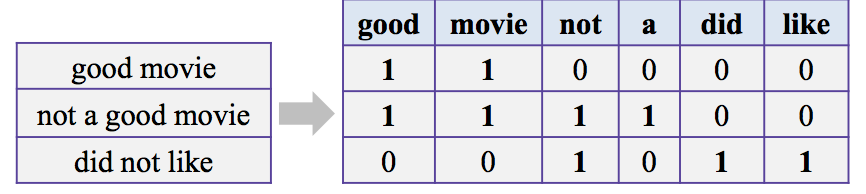

In [ ]:
rmse = lambda y_true, y_pred: np.sqrt(mse(y_true, y_pred))
rmse_loss = lambda Estimator, X, y: rmse(y, Estimator.predict(X))

In [ ]:
# how to define X and y (from the SMS data) for use with COUNTVECTORIZER
x = train_df['excerpt_clean']
y = train_df['target']

print(len(x), len(y))

In [ ]:
# Split into train and test sets
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

In [ ]:
model = make_pipeline(
    CountVectorizer(ngram_range=(1,1)),
    LinearRegression(),
)

val_score = cross_val_score(
    model, 
    train_df['excerpt_clean'], 
    train_df['target'], 
    scoring=rmse_loss
).mean()

console.print(f'Train Score for CountVectorizer(1,1): {val_score}')

In [ ]:
model = make_pipeline(
    CountVectorizer(ngram_range=(2,2)),
    LinearRegression(),
)

val_score = cross_val_score(
    model, 
    train_df['excerpt_clean'], 
    train_df['target'], 
    scoring=rmse_loss
).mean()

console.print(f'Train Score for CountVectorizer(1,1): {val_score}')

In [ ]:
model = make_pipeline(
    CountVectorizer(ngram_range=(1,2)),
    LinearRegression(),
)

val_score = cross_val_score(
    model, 
    train_df['excerpt_clean'], 
    train_df['target'], 
    scoring=rmse_loss
).mean()

console.print(f'Train Score for CountVectorizer(1,1): {val_score}')

In [ ]:
# Now create the train and test dtm
vect = CountVectorizer()
vect.fit(x_train)

# Use the trained to create a document-term matrix from train and test sets
x_train_dtm = vect.transform(x_train)
x_test_dtm = vect.transform(x_test)

In [ ]:
vect_tunned = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.1, max_df=0.7, max_features=100)

In [ ]:
model = make_pipeline(
    TfidfVectorizer(ngram_range=(1,1)),
    LinearRegression()
)

val_score = cross_val_score(
    model, 
    train_df['excerpt_clean'], 
    train_df['target'], 
    scoring=rmse_loss
).mean()

console.print(f'Train Score for TfidfVectorizer(1,1): {val_score}')

In [ ]:
model = make_pipeline(
    TfidfVectorizer(ngram_range=(1,2)),
    LinearRegression()
)

val_score = cross_val_score(
    model, 
    train_df['excerpt_clean'], 
    train_df['target'], 
    scoring=rmse_loss
).mean()

console.print(f'Train Score for TfidfVectorizer(1,1): {val_score}')

Again, the best selection for `ngram` parameter is the tuple `(1,2)`.

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

tfidf_transformer.fit(x_train_dtm)
x_train_tfidf = tfidf_transformer.transform(x_train_dtm)

x_train_tfidf

<a id='5.3'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">5.3 Word Embeddings: GloVe</p>

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

In [ ]:
texts = train_df['excerpt_clean']
target = train_df['target']

In [ ]:
# Calculate the length of our vocabulary
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(texts)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

In [ ]:
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

longest_train = max(texts, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = pad_sequences(
    embed(texts), 
    length_long_sentence, 
    padding='post'
)

train_padded_sentences

In [ ]:
text_test = test_df["excerpt_clean"]
word_tokenizer2 = Tokenizer()
word_tokenizer2.fit_on_texts(text_test)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

longest_test = max(text_test, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_test))

test_padded_sentences = pad_sequences(
    embed(text_test), 
    length_long_sentence, 
    padding='post'
)

test_padded_sentences

In [ ]:
embeddings_dictionary = dict()
embedding_dim = 100

# Load GloVe 100D embeddings
with open('/kaggle/input/glove6b100dtxt/glove.6B.100d.txt') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions

In [ ]:
# Now we will load embedding vectors of those words that appear in the
# Glove dictionary. Others will be initialized to 0.

embedding_matrix = np.zeros((vocab_length, embedding_dim))
print(len(embedding_matrix))
print(len(word_tokenizer.word_index.items()))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
embedding_matrix

<a href="#table-of-content">back to table of content</a>
<a id='6'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">6. Modeling</p>

<a id='6.1'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">6.1 TF-IDF with XGBoost</p>

In [ ]:
from sklearn.pipeline import Pipeline
import xgboost as xgb

pipe = Pipeline([
    ('tfid', TfidfVectorizer(ngram_range=(1,2))),  
    ('model', xgb.XGBRegressor(
        learning_rate=0.1,
        max_depth=7,
        n_estimators=80,
        use_label_encoder=False,
        eval_metric='rmse',
    ))
])

# Fit the pipeline with the data
pipe.fit(x_train, y_train)

In [ ]:
y_pred = pipe.predict(x_test)

console.print(f'Score for XGBoost with TfidfVectorizer(1,2): {rmse(y_test, y_pred)}')

<a href="#table-of-content">back to table of content</a>
<a id='7'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">7. LSTM</p>

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    train_padded_sentences, 
    target, 
    test_size=0.25
)

In [ ]:
# Model from https://www.kaggle.com/mariapushkareva/nlp-disaster-tweets-with-glove-and-lstm/data

def glove_lstm():
    model = Sequential()
    
    model.add(Embedding(
        input_dim=embedding_matrix.shape[0], 
        output_dim=embedding_matrix.shape[1], 
        weights = [embedding_matrix], 
        input_length=length_long_sentence
    ))
    
    model.add(Bidirectional(LSTM(
        length_long_sentence, 
        return_sequences = True, 
        recurrent_dropout=0.2
    )))
    
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'linear'))
    
    model.compile(Adam(lr=1e-5), loss='mean_squared_error', metrics=[RootMeanSquaredError()])
    
    return model

model = glove_lstm()
model.summary()

In [ ]:
# Load the model and train!!

model = glove_lstm()

checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)
history = model.fit(
    X_train, 
    y_train, 
    epochs = 100,
    batch_size = 32,
    validation_data = (X_test, y_test),
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)

In [ ]:
def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

In [ ]:
plot_learning_curves(history, [['loss', 'val_loss'],['root_mean_squared_error', 'val_root_mean_squared_error']])

In [ ]:
y_pred = model.predict(test_padded_sentences)
print(y_pred)
predictions = pd.DataFrame()
predictions['id'] = test_df['id']
predictions['target'] = y_pred
predictions.to_csv("submission.csv", index=False)